<a href="https://colab.research.google.com/github/22083111/Ability-to-predict-Age-and-Gender-from-Facial-Images/blob/main/IDK%402_FINAL_DRAFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/nikhil')


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import necessary libraries for data handling, model building, and training
import cv2
import shutil
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import seaborn as sns
from io import BytesIO
from scipy.stats import zscore
import matplotlib.pyplot as plt
from src.train import build_model
from collections import defaultdict
from src.evaluate import evaluate_model
from tensorflow.keras.models import Model
from IPython.display import Image, display
from tensorflow.keras.optimizers import Adam
from src.preprocess import preprocess_images
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization



In [ ]:

def create_target_folder(target_path):
    """
    Ensure the target folder exists or create it.

    Args:
        target_path (str): Path to the target folder.
    """
    os.makedirs(target_path, exist_ok=True)
    print(f"Target folder '{target_path}' is ready.")

def extract_age_from_filename(filename):
    """
    Extract the age from the filename.

    Args:
        filename (str): Filename formatted as [random]_[age]_[gender]_[etc].jpg.

    Returns:
        int or None: Extracted age if successful, None otherwise.
    """
    try:
        age = int(filename.split('_')[1])
        return age
    except (ValueError, IndexError):
        print(f"Could not extract age from filename: {filename}")
        return None

def copy_images_by_age(source_path, target_path, max_images_per_age=20):
    """
    Copy up to a specified number of images per age group from source to target folder.

    Args:
        source_path (str): Path to the folder containing source images.
        target_path (str): Path to the folder to copy selected images.
        max_images_per_age (int): Maximum number of images to copy for each age group.

    Returns:
        defaultdict: Dictionary containing the count of images moved per age group.
    """
    age_counts = defaultdict(int)

    for filename in os.listdir(source_path):
        image_path = os.path.join(source_path, filename)

        # Skip non-file entries
        if not os.path.isfile(image_path):
            print(f"File {image_path} does not exist, skipping.")
            continue

        # Extract age from filename
        age = extract_age_from_filename(filename)

        # Check if the image already exists in the target folder
        target_image_path = os.path.join(target_path, filename)
        if os.path.exists(target_image_path):
            print(f"File {target_image_path} already exists, skipping.")
            continue

        # Copy image if age limit for the group is not exceeded
        if age is not None and age_counts[age] < max_images_per_age:
            shutil.copy(image_path, target_image_path)
            age_counts[age] += 1

    return age_counts

def display_summary(age_counts):
    """
    Display the summary of images moved for each age group.

    Args:
        age_counts (defaultdict): Dictionary with the count of images moved per age group.
    """
    for age, count in age_counts.items():
        print(f"Moved {count} images for age {age}.")
    print("Image selection and moving complete.")

# -----------------------------------------------
# Workflow
# -----------------------------------------------

# Define paths
all_images_path = '/content/drive/MyDrive/nikhil/data/all_images'
finalised_images_path = '/content/drive/MyDrive/nikhil/finalised_images'

# Ensure the target folder is ready
create_target_folder(finalised_images_path)

# Copy images by age group and limit to 20 per age
age_counts = copy_images_by_age(all_images_path, finalised_images_path, max_images_per_age=20)

# Display the summary
display_summary(age_counts)


Target folder '/content/drive/MyDrive/nikhil/finalised_images' is ready.
File /content/drive/MyDrive/nikhil/finalised_images/26_1_4_20170117152504299.jpg already exists, skipping.
File /content/drive/MyDrive/nikhil/finalised_images/26_1_3_20170117174603671.jpg already exists, skipping.
File /content/drive/MyDrive/nikhil/finalised_images/26_1_3_20170117174605432.jpg already exists, skipping.
File /content/drive/MyDrive/nikhil/finalised_images/aligned_32_1_0_20170117182452621.jpg already exists, skipping.
File /content/drive/MyDrive/nikhil/finalised_images/aligned_32_1_0_20170117180018829.jpg already exists, skipping.
File /content/drive/MyDrive/nikhil/finalised_images/aligned_32_1_0_20170117185523010.jpg already exists, skipping.
File /content/drive/MyDrive/nikhil/finalised_images/26_1_3_20170117174556511.jpg already exists, skipping.
File /content/drive/MyDrive/nikhil/finalised_images/26_1_4_20170117152642036.jpg already exists, skipping.
File /content/drive/MyDrive/nikhil/finalised_im

In [ ]:


def check_directory_exists(input_path):
    """
    Checks if the specified directory exists.

    Args:
        input_path (str): Path to the directory.

    Raises:
        FileNotFoundError: If the directory does not exist.
    """
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input path '{input_path}' does not exist.")

def resize_and_overwrite_image(image_path, img_size):
    """
    Reads, resizes, and overwrites an image at the specified path.

    Args:
        image_path (str): Path to the image file.
        img_size (tuple): Desired size for resizing the image.

    Returns:
        bool: True if the operation was successful, False otherwise.
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Invalid image file: {image_path}")
            return False
        resized_img = cv2.resize(img, img_size)
        cv2.imwrite(image_path, resized_img)
        return True
    except Exception as e:
        print(f"Error resizing image {image_path}: {e}")
        return False

def extract_metadata_from_filename(filename):
    """
    Extracts metadata (age and gender) from the filename.

    Args:
        filename (str): Filename formatted as [prefix]_[age]_[gender]_[suffix].jpg.

    Returns:
        dict or None: A dictionary with extracted metadata ('age', 'gender') or None if an error occurs.
    """
    try:
        parts = filename.split('_')
        age = int(parts[1])
        gender = int(parts[2])
        return {'age': age, 'gender': gender}
    except (IndexError, ValueError) as e:
        print(f"Error extracting metadata from {filename}: {e}")
        return None

def preprocess_images(input_path, img_size=(224, 224)):
    """
    Preprocesses images in the specified folder by resizing and extracting metadata.

    Args:
        input_path (str): Path to the folder containing images.
        img_size (tuple): Desired size for resizing images (default: (224, 224)).

    Returns:
        pd.DataFrame: A DataFrame containing metadata for processed images.
    """
    check_directory_exists(input_path)
    metadata = []

    print("Starting preprocessing from the finalised_images path...")

    for file in tqdm(os.listdir(input_path), desc="Processing Images"):
        img_path = os.path.join(input_path, file)

        # Resize and overwrite the image
        if resize_and_overwrite_image(img_path, img_size):
            # Extract metadata from filename
            meta = extract_metadata_from_filename(file)
            if meta:
                meta['filename'] = file
                meta['img_path'] = img_path
                metadata.append(meta)

    # Create metadata DataFrame
    metadata_df = pd.DataFrame(metadata)

    # Save metadata to a CSV file
    metadata_csv_path = os.path.join(input_path, 'metadata.csv')
    metadata_df.to_csv(metadata_csv_path, index=False)
    print(f"Preprocessing complete. Metadata saved to {metadata_csv_path}.")

    return metadata_df

# -----------------------------------------------
# Workflow
# -----------------------------------------------

# Define the path for the folder containing finalised images
finalised_images_path = '/content/drive/MyDrive/nikhil/finalised_images'

# Call the function to preprocess images
metadata_df = preprocess_images(finalised_images_path)

# Display the first few rows of the metadata for verification
print(metadata_df.head())


Starting preprocessing from the finalised_images path...


Processing Images:  38%|███▊      | 1010/2684 [00:47<00:14, 114.31it/s]

Invalid image file: /content/drive/MyDrive/nikhil/finalised_images/metadata.csv


Processing Images:  43%|████▎     | 1155/2684 [00:48<00:14, 108.82it/s]

Error extracting metadata from aligned_53__0_20170116184028385.jpg: invalid literal for int() with base 10: ''


Processing Images:  73%|███████▎  | 1947/2684 [00:55<00:07, 97.09it/s] 

Error extracting metadata from 61_3_20170109150557335.jpg: invalid literal for int() with base 10: '20170109150557335.jpg'


Processing Images: 100%|██████████| 2684/2684 [01:02<00:00, 42.66it/s] 


Preprocessing complete. Metadata saved to /content/drive/MyDrive/nikhil/finalised_images/metadata.csv.
   age  gender                              filename  \
0   52       0  aligned_52_0_2_20170116192904934.jpg   
1   54       0  aligned_54_0_2_20170116193431300.jpg   
2   54       0  aligned_54_0_2_20170116193316730.jpg   
3   54       0  aligned_54_0_0_20170116193518166.jpg   
4   54       0  aligned_54_0_2_20170116193435159.jpg   

                                            img_path  
0  /content/drive/MyDrive/nikhil/finalised_images...  
1  /content/drive/MyDrive/nikhil/finalised_images...  
2  /content/drive/MyDrive/nikhil/finalised_images...  
3  /content/drive/MyDrive/nikhil/finalised_images...  
4  /content/drive/MyDrive/nikhil/finalised_images...  


Dataset Loaded Successfully!
General Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2681 entries, 0 to 2680
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       2681 non-null   int64 
 1   gender    2681 non-null   int64 
 2   filename  2681 non-null   object
 3   img_path  2681 non-null   object
dtypes: int64(2), object(2)
memory usage: 83.9+ KB
None

Statistical Summary:
               age       gender
count  2681.000000  2681.000000
mean     40.169340     0.353972
std      18.690798     0.636888
min       0.000000     0.000000
25%      27.000000     0.000000
50%      39.000000     0.000000
75%      54.000000     1.000000
max     115.000000     4.000000

Missing Values:
age         0
gender      0
filename    0
img_path    0
dtype: int64


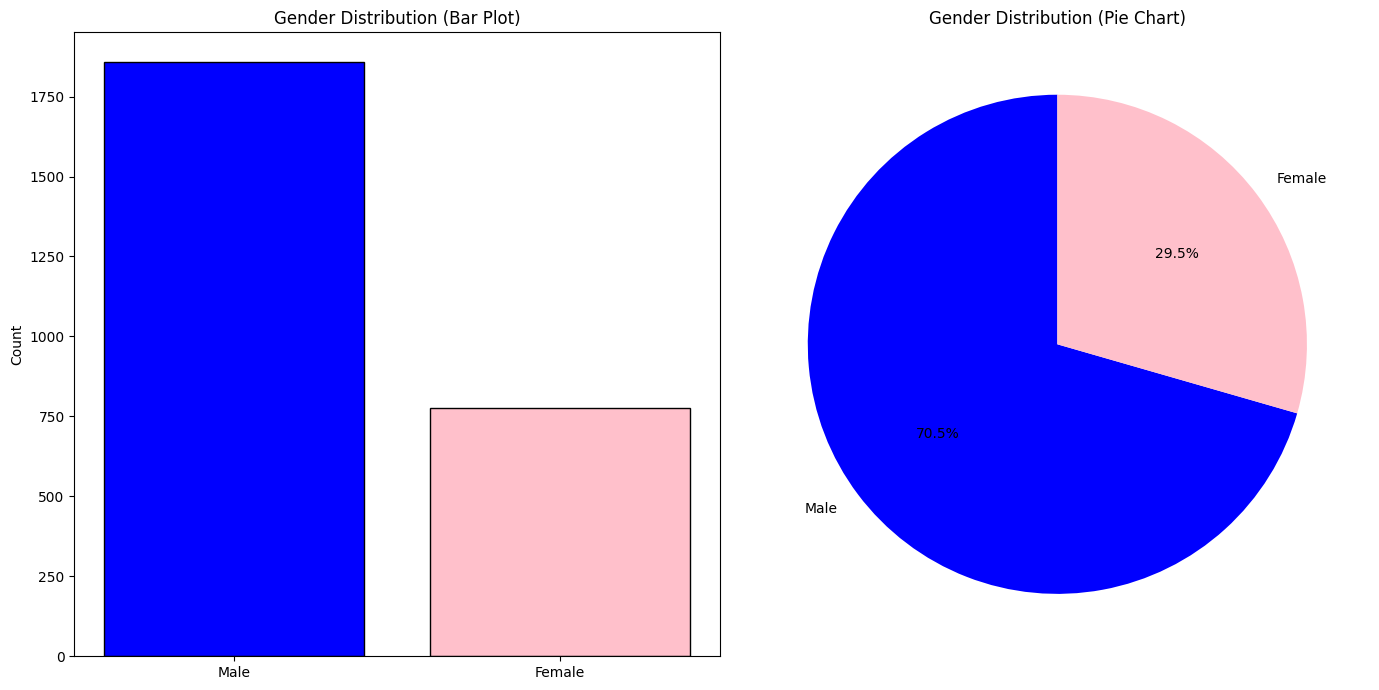

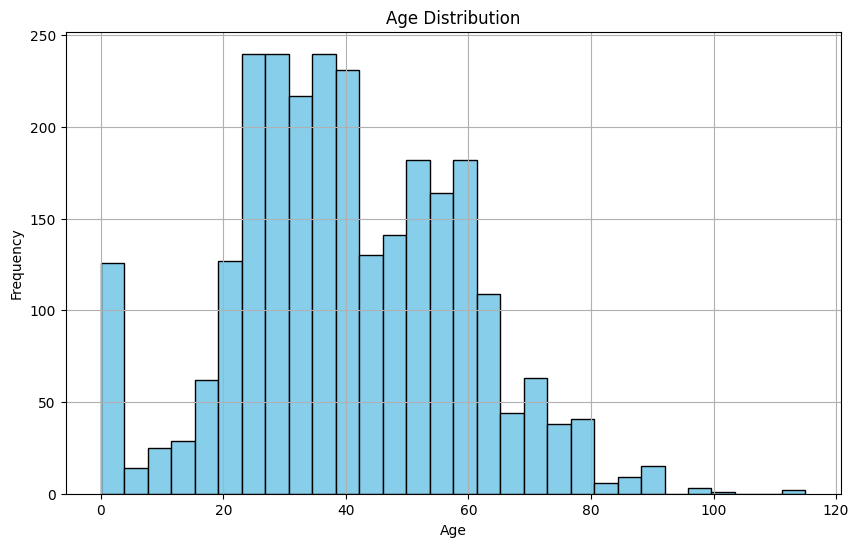

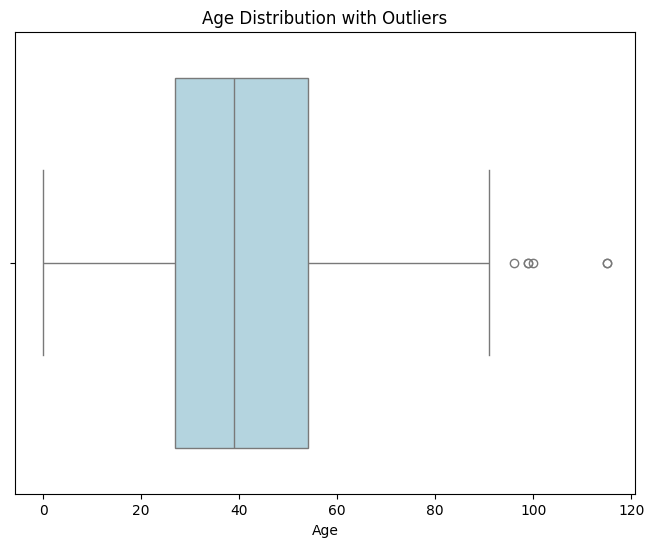

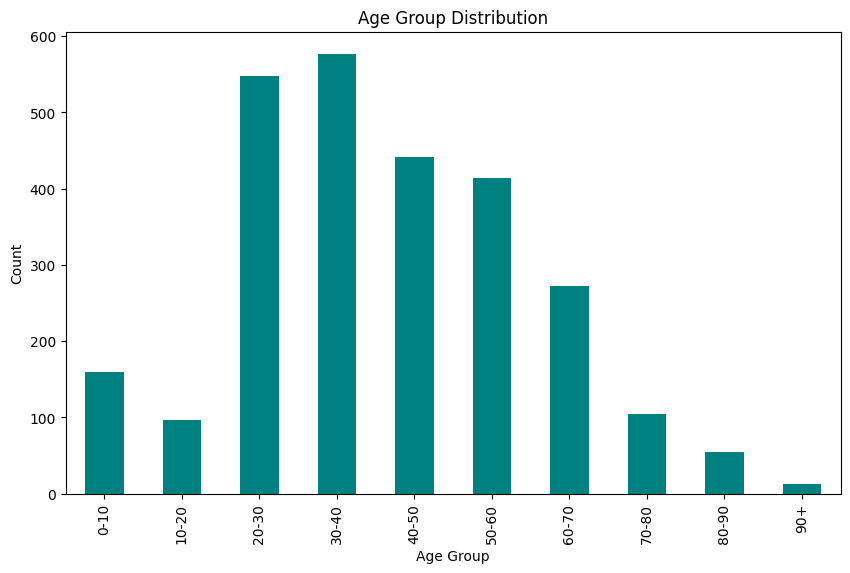

<ipython-input-6-52d2baa610c6>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='age', data=df, palette='coolwarm')


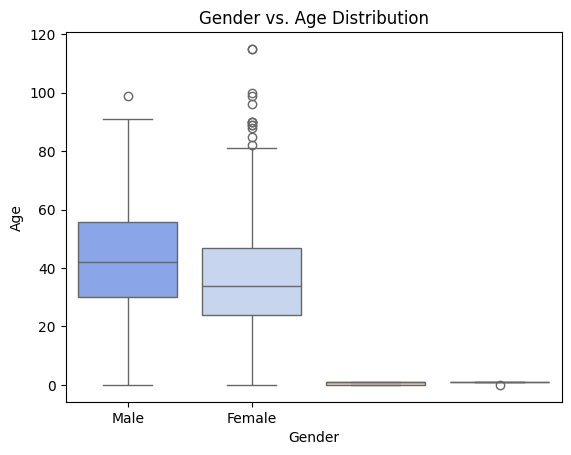

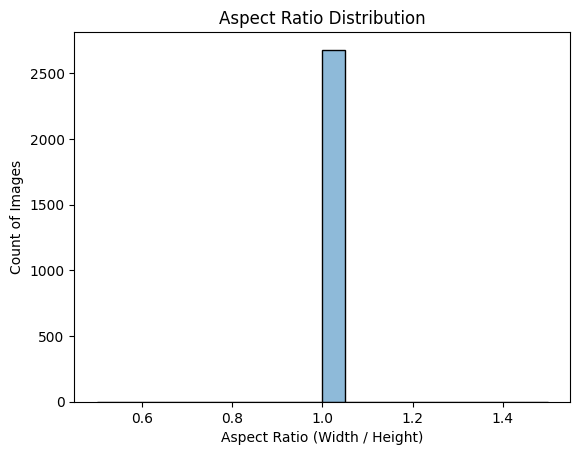

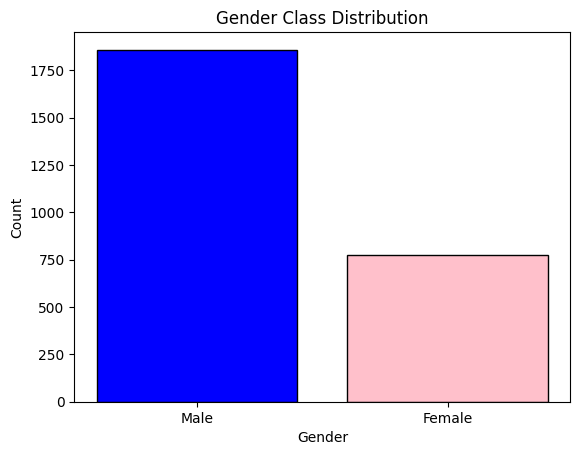

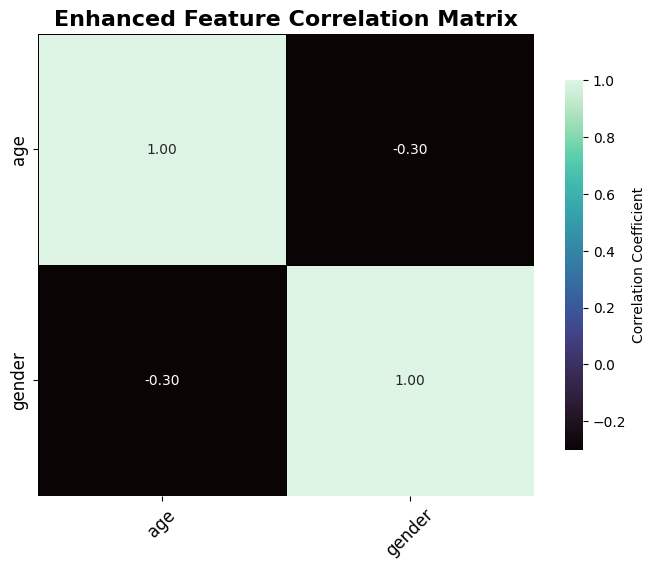

Number of outliers in age: 5


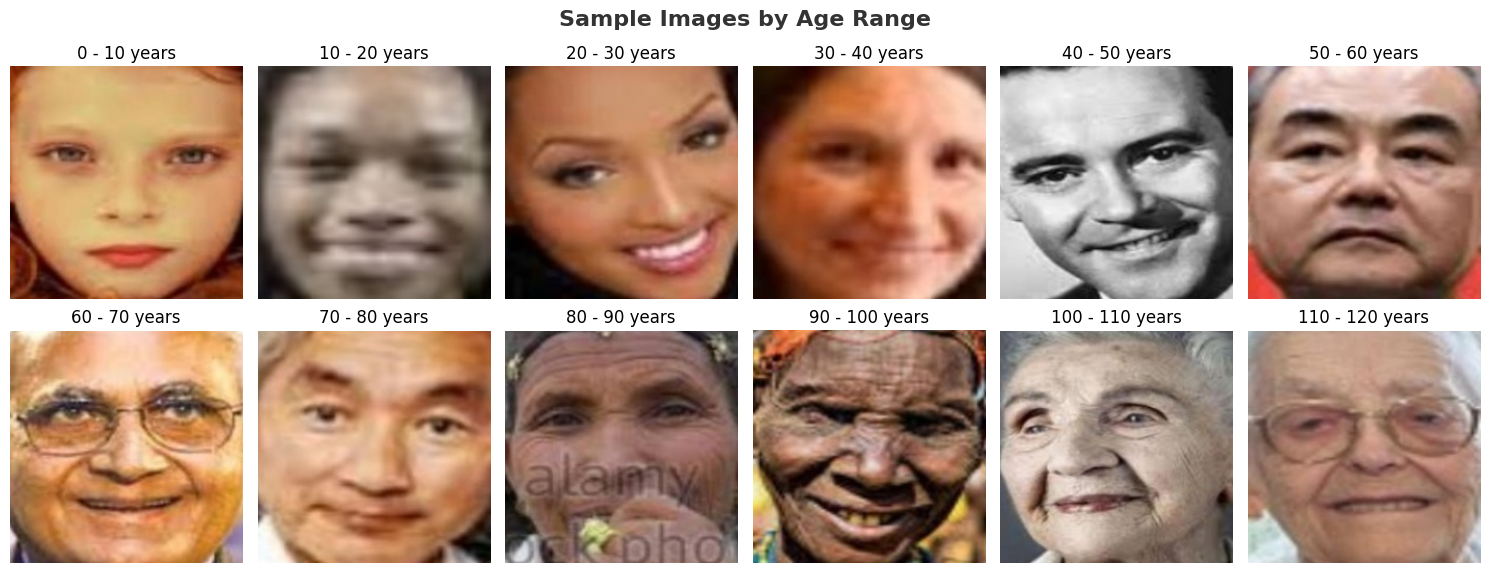

In [ ]:
#Exploratory Data Analysis (EDA)

def load_dataset(file_path):
    """
    Loads the dataset from the specified file path.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully!")
    return df

def display_general_info(df):
    """
    Displays general information about the dataset.

    Args:
        df (pd.DataFrame): The dataset.
    """
    print("General Information:")
    print(df.info())
    print("\nStatistical Summary:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())

def plot_gender_distribution(df):
    """
    Plots the gender distribution as bar and pie charts.

    Args:
        df (pd.DataFrame): The dataset.
    """
    # Filter valid genders
    df = df[df['gender'].isin([0, 1])]

    male_count = df[df['gender'] == 0].shape[0]
    female_count = df[df['gender'] == 1].shape[0]

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].bar(['Male', 'Female'], [male_count, female_count], color=['blue', 'pink'], edgecolor='black')
    axes[0].set_title('Gender Distribution (Bar Plot)')
    axes[0].set_ylabel('Count')

    axes[1].pie([male_count, female_count], labels=['Male', 'Female'], autopct='%1.1f%%', colors=['blue', 'pink'], startangle=90)
    axes[1].set_title('Gender Distribution (Pie Chart)')
    plt.tight_layout()
    plt.show()

def plot_age_distribution(df):
    """
    Plots the age distribution as a histogram and a box plot.

    Args:
        df (pd.DataFrame): The dataset.
    """
    plt.figure(figsize=(10, 6))
    df['age'].hist(bins=30, color='skyblue', edgecolor='black')
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df['age'], color='lightblue')
    plt.title('Age Distribution with Outliers')
    plt.xlabel('Age')
    plt.show()

def plot_age_groups(df):
    """
    Plots the age distribution as grouped bins.

    Args:
        df (pd.DataFrame): The dataset.
    """
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

    age_group_counts = df['age_group'].value_counts().sort_index()
    age_group_counts.plot(kind='bar', color='teal', figsize=(10, 6))
    plt.title('Age Group Distribution')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.show()

def plot_gender_vs_age(df):
    """
    Plots the distribution of age by gender.

    Args:
        df (pd.DataFrame): The dataset.
    """
    sns.boxplot(x='gender', y='age', data=df, palette='coolwarm')
    plt.title('Gender vs. Age Distribution')
    plt.xticks([0, 1], ['Male', 'Female'])
    plt.xlabel('Gender')
    plt.ylabel('Age')
    plt.show()

def analyze_image_metadata(df):
    """
    Analyzes image metadata and plots aspect ratio distribution.

    Args:
        df (pd.DataFrame): The dataset.

    Returns:
        pd.DataFrame: Updated dataset with image width, height, and aspect ratio.
    """
    image_dimensions = [Image.open(path).size for path in df['img_path']]
    df['width'], df['height'] = zip(*image_dimensions)

    df['aspect_ratio'] = df['width'] / df['height']
    sns.histplot(df['aspect_ratio'], bins=20, kde=True)
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (Width / Height)')
    plt.ylabel('Count of Images')
    plt.show()

    return df

def check_class_imbalance(df):
    """
    Checks and plots the gender class distribution.

    Args:
        df (pd.DataFrame): The dataset.
    """
    df = df[df['gender'].isin([0, 1])]
    gender_counts = df['gender'].value_counts()

    plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'], edgecolor='black')
    plt.title('Gender Class Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
    plt.show()

def plot_correlation_matrix(df):
    """
    Plots the correlation matrix for numerical features.

    Args:
        df (pd.DataFrame): The dataset.
    """
    numerical_columns = df.select_dtypes(include=['number'])
    numerical_columns = numerical_columns.loc[:, (numerical_columns.var() > 0)]
    correlation_matrix = numerical_columns.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='mako',
        fmt=".2f",
        linewidths=0.5,
        linecolor='black',
        cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8}
    )
    plt.title("Enhanced Feature Correlation Matrix", fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.show()

def detect_outliers(df):
    """
    Detects outliers in the age column using z-scores.

    Args:
        df (pd.DataFrame): The dataset.

    Returns:
        pd.DataFrame: DataFrame containing the outliers.
    """
    df['age_zscore'] = zscore(df['age'])
    outliers = df[df['age_zscore'].abs() > 3]
    print(f"Number of outliers in age: {len(outliers)}")
    return outliers

def visualize_images_by_age_range(df, age_ranges, img_dir):
    """
    Visualizes a sample image for each age range from the dataset.

    Args:
        df (pd.DataFrame): The dataset containing image paths and age information.
        age_ranges (list): List of tuples representing age ranges (min_age, max_age).
        img_dir (str): Path to the directory containing images.
    """
    num_rows = 2
    num_cols = 6
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6))
    axs = axs.ravel()

    for i, (min_age, max_age) in enumerate(age_ranges):
        subset_df = df[(df['age'] >= min_age) & (df['age'] < max_age)]
        if not subset_df.empty:
            random_img_path = subset_df.sample(1)['img_path'].values[0]
            img = Image.open(os.path.join(img_dir, random_img_path))
            axs[i].imshow(img)
            axs[i].set_title(f"{min_age} - {max_age} years")
            axs[i].axis('off')
        else:
            axs[i].axis('off')

    fig.suptitle("Sample Images by Age Range", fontsize=16, fontweight='bold', color="#333")
    plt.tight_layout()
    plt.show()

# Execute EDA Functions
data_path = '/content/drive/MyDrive/nikhil/finalised_images/metadata.csv'
df = load_dataset(data_path)
display_general_info(df)
plot_gender_distribution(df)
plot_age_distribution(df)
plot_age_groups(df)
plot_gender_vs_age(df)
df = analyze_image_metadata(df)
check_class_imbalance(df)
plot_correlation_matrix(df)
outliers = detect_outliers(df)

# Visualize images by age range
age_ranges = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 100), (100, 110), (110, 120)]
image_dir = '/content/drive/MyDrive/nikhil/finalised_images'
visualize_images_by_age_range(df, age_ranges, image_dir)


DATA PREPARATION

In [ ]:

def shuffle_and_split_data(df, test_size=0.2, random_state=42):
    """
    Shuffles the dataset and splits it into training and testing sets.

    Args:
        df (pd.DataFrame): The dataset to be shuffled and split.
        test_size (float): Proportion of the dataset to include in the test split (default: 0.2).
        random_state (int): Seed used by the random number generator for reproducibility (default: 42).

    Returns:
        tuple: A tuple containing two DataFrames:
            - train_df: Training dataset.
            - test_df: Testing dataset.
    """
    # Shuffle the dataset
    df_shuffled = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    print("Data shuffled successfully.")

    # Split the dataset
    train_df, test_df = train_test_split(df_shuffled, test_size=test_size, random_state=random_state)
    print(f"Data split successfully: {len(train_df)} training samples, {len(test_df)} testing samples.")

    return train_df, test_df

def define_data_generators():
    """
    Defines data augmentation for the training data and rescaling for the testing data.

    Returns:
        tuple: A tuple containing:
            - train_datagen (ImageDataGenerator): Data augmentation generator for training data.
            - test_datagen (ImageDataGenerator): Rescaling generator for testing data.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2
    )
    test_datagen = ImageDataGenerator(rescale=1./255)
    print("Data generators defined: Augmentation for training and rescaling for testing.")
    return train_datagen, test_datagen

# Workflow
# 1. Shuffle and split the dataset
# Assuming `df` is the loaded and processed dataset
train_df, test_df = shuffle_and_split_data(df, test_size=0.2, random_state=42)

# 2. Define data augmentation and rescaling
train_datagen, test_datagen = define_data_generators()


Data shuffled successfully.
Data split successfully: 2144 training samples, 537 testing samples.
Data generators defined: Augmentation for training and rescaling for testing.


In [ ]:


def custom_generator(df, file_path, batch_size, datagen, class_weights=None):
    """
    Custom generator to process data in batches, including image preprocessing
    and handling multi-output labels for age and gender.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        file_path (str): Base directory containing the image files.
        batch_size (int): Number of samples per batch.
        datagen (ImageDataGenerator): Data augmentation or rescaling generator.
        class_weights (dict, optional): Class weights for gender labels to handle class imbalance.

    Yields:
        tuple: A tuple containing:
            - img_batch (np.array): Batch of preprocessed image data.
            - labels (dict): Dictionary with `age_out` and `gender_out` as keys.
            - weights (np.array): Array of weights for each sample in the batch.
    """
    while True:
        # Shuffle the data for each epoch
        df_shuffled = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df), batch_size):
            batch_df = df_shuffled.iloc[i:i + batch_size]
            img_batch = []
            age_batch = []
            gender_batch = []

            for _, row in batch_df.iterrows():
                img_path = os.path.join(file_path, row['img_path'])
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img) / 255.0
                img_batch.append(img_array)
                age_batch.append(row['age'])
                gender_batch.append(row['gender'])

            img_batch = np.array(img_batch)
            age_batch = np.array(age_batch)
            gender_batch = np.array(gender_batch)

            # Apply class weights if provided
            if class_weights is not None:
                weights = np.array([class_weights.get(label, 1.0) for label in gender_batch])
            else:
                weights = np.ones_like(gender_batch)

            yield img_batch, {'age_out': age_batch, 'gender_out': gender_batch}, weights


In [ ]:


def build_multi_output_model(base_model, trainable_layers=4):
    """
    Builds a multi-output model for age and gender prediction using a pre-trained base model.

    Args:
        base_model (Model): A pre-trained model (e.g., VGG16, ResNet50, EfficientNetB0).
        trainable_layers (int): Number of trainable layers from the end of the base model.

    Returns:
        Model: A Keras model with multi-output for age (regression) and gender (binary classification) prediction.
    """
    # Set the base model layers to non-trainable except for the last `trainable_layers`
    base_model.trainable = True
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False

    # Get the output of the base model
    output = base_model.layers[-1].output
    flatten = Flatten()(output)

    # Age prediction branch
    age_dense1 = Dense(units=126, activation='relu')(flatten)
    age_dropout_layer = Dropout(rate=0.3)(age_dense1)
    age_output = Dense(1, activation='linear', name='age_out')(age_dropout_layer)

    # Gender prediction branch
    gender_dense1 = Dense(units=256, activation='relu')(flatten)
    gender_bn1 = BatchNormalization()(gender_dense1)
    gender_dropout_layer = Dropout(rate=0.4)(gender_bn1)
    gender_output = Dense(1, activation='sigmoid', name='gender_out')(gender_dropout_layer)

    # Combine age and gender branches into a single model
    model = Model(inputs=base_model.input, outputs=[age_output, gender_output])
    print(f"Multi-output model built successfully with {base_model.name}.")
    return model

def build_and_compile_models():
    """
    Builds and compiles multiple models (VGG16, ResNet50, EfficientNetB0) for age and gender prediction.

    Returns:
        dict: A dictionary with model names as keys and compiled Keras models as values.

    Workflow:
        1. Defines base models (e.g., VGG16, ResNet50, EfficientNetB0).
        2. Builds a multi-output model for each base model using `build_multi_output_model`.
        3. Compiles the models with Adam optimizer, age regression loss (MSE), and gender classification loss (binary crossentropy).
    """
    models = {}

    # Define base models
    base_models = {
        "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    }

    # Build and compile each model
    for name, base_model in base_models.items():
        # Build the multi-output model
        model = build_multi_output_model(base_model, trainable_layers=6 if name == "EfficientNetB0" else 4)

        # Compile the model
        model.compile(
            optimizer='adam',
            loss={'age_out': 'mean_squared_error', 'gender_out': 'binary_crossentropy'},
            metrics={'age_out': 'mae', 'gender_out': 'accuracy'}
        )
        models[name] = model
        print(f"{name} model compiled successfully.")

    return models

# Workflow
if __name__ == "__main__":
    # Build and compile the models
    models = build_and_compile_models()

    # Example: Accessing the VGG16 model
    vgg16_model = models["VGG16"]


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Multi-output model built successfully with vgg16.
VGG16 model compiled successfully.
Multi-output model built successfully with resnet50.
ResNet50 model compiled successfully.
Multi-output model built successfully with efficientnetb0.
EfficientNetB0 model compiled successfully.


Plotting architecture for VGG16...


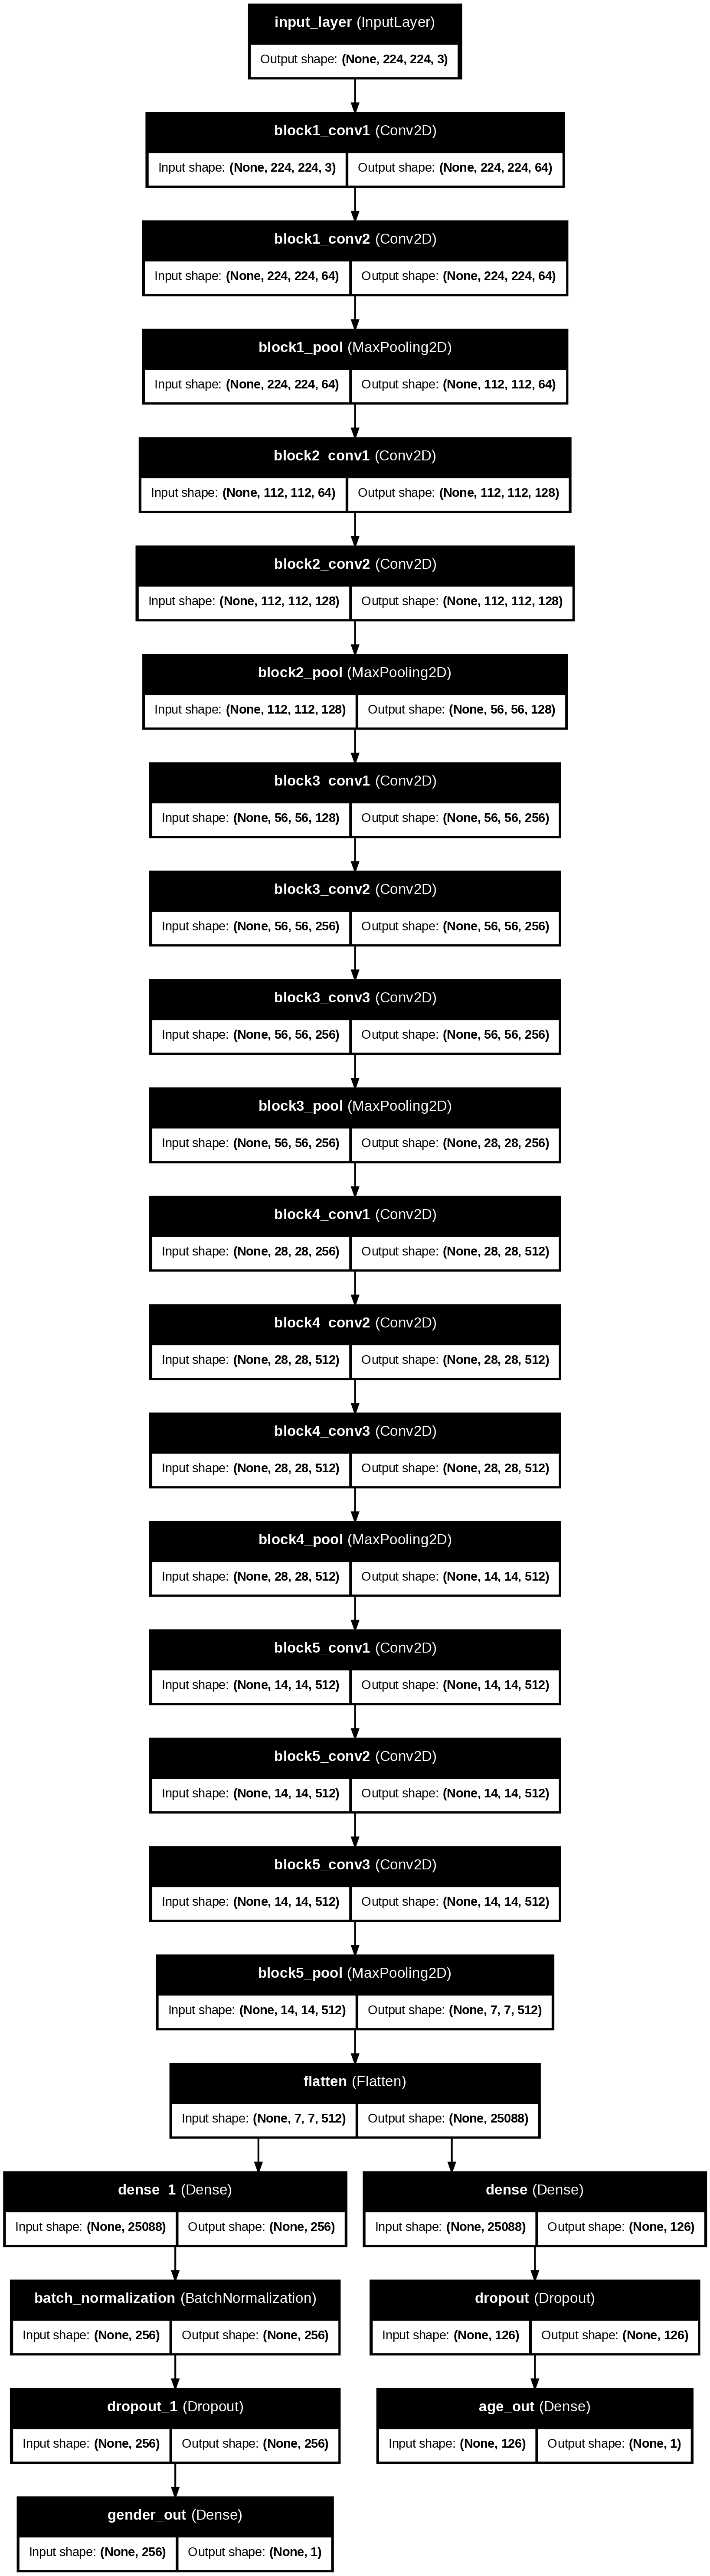

VGG16 architecture displayed successfully.

Plotting architecture for ResNet50...
Error displaying ResNet50 architecture: Program terminated with status: -6. stderr follows: failed at node 13052[1]
dot: maze.c:313: chkSgraph: Assertion `np->cells[1]' failed.

Plotting architecture for EfficientNetB0...
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.53989 to fit



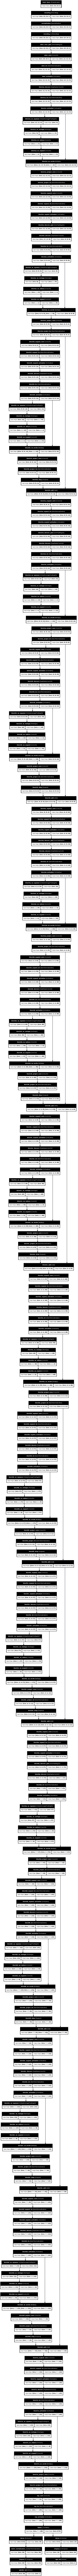

EfficientNetB0 architecture displayed successfully.



In [ ]:

def plot_model_inline(model, model_name):
    """
    Plots the architecture of the given model and displays it inline in the output panel.

    Args:
        model (tf.keras.Model): The Keras model to plot.
        model_name (str): Name of the model (for labeling).
    """
    print(f"Plotting architecture for {model_name}...")
    # Save the plot temporarily in memory and display it
    try:
        # Save the model plot to a temporary file
        temp_file = f"{model_name}_temp.png"
        plot_model(
            model,
            to_file=temp_file,
            show_shapes=True,
            show_layer_names=True,
            dpi=150
        )

        # Display the plot inline
        display(Image(temp_file))
        print(f"{model_name} architecture displayed successfully.\n")
    except Exception as e:
        print(f"Error displaying {model_name} architecture: {e}")

# Example Workflow with Multiple Models
def plot_all_models_inline(models):
    """
    Plots the architectures of multiple models and displays them inline.

    Args:
        models (dict): A dictionary of model names and their corresponding Keras models.
    """
    for model_name, model in models.items():
        plot_model_inline(model, model_name)

# Assuming `models` is a dictionary containing VGG16, ResNet50, and EfficientNetB0
plot_all_models_inline(models)


MOdel Training

In [ ]:


def create_early_stopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1):
    """
    Creates an EarlyStopping callback to stop training when the monitored metric stops improving.

    Args:
        monitor (str): Metric to monitor (default: 'val_loss').
        patience (int): Number of epochs with no improvement after which training will stop (default: 10).
        restore_best_weights (bool): Whether to restore the model's weights from the best epoch (default: True).
        verbose (int): Verbosity mode (default: 1).

    Returns:
        EarlyStopping: Configured EarlyStopping callback.
    """
    return EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=restore_best_weights,
        verbose=verbose
    )

def create_reduce_lr(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, cooldown=0, verbose=1):
    """
    Creates a ReduceLROnPlateau callback to reduce the learning rate when the monitored metric stops improving.

    Args:
        monitor (str): Metric to monitor (default: 'val_loss').
        factor (float): Factor by which the learning rate will be reduced (default: 0.2).
        patience (int): Number of epochs with no improvement after which learning rate will be reduced (default: 3).
        min_lr (float): Minimum learning rate (default: 1e-6).
        cooldown (int): Number of epochs to wait before resuming LR reductions (default: 0).
        verbose (int): Verbosity mode (default: 1).

    Returns:
        ReduceLROnPlateau: Configured ReduceLROnPlateau callback.
    """
    return ReduceLROnPlateau(
        monitor=monitor,
        factor=factor,
        patience=patience,
        min_lr=min_lr,
        cooldown=cooldown,
        verbose=verbose
    )

def setup_callbacks(monitor='val_loss', early_stopping_patience=10, reduce_lr_patience=3, reduce_lr_factor=0.2, min_lr=1e-6, verbose=1):
    """
    Sets up and returns a list of callbacks for model training.

    Args:
        monitor (str): Metric to monitor (default: 'val_loss').
        early_stopping_patience (int): Patience for EarlyStopping (default: 10).
        reduce_lr_patience (int): Patience for ReduceLROnPlateau (default: 3).
        reduce_lr_factor (float): Factor for ReduceLROnPlateau (default: 0.2).
        min_lr (float): Minimum learning rate for ReduceLROnPlateau (default: 1e-6).
        verbose (int): Verbosity mode for callbacks (default: 1).

    Returns:
        list: List of callbacks [EarlyStopping, ReduceLROnPlateau].
    """
    # Create EarlyStopping callback
    early_stopping = create_early_stopping(
        monitor=monitor,
        patience=early_stopping_patience,
        restore_best_weights=True,
        verbose=verbose
    )

    # Create ReduceLROnPlateau callback
    reduce_lr = create_reduce_lr(
        monitor=monitor,
        factor=reduce_lr_factor,
        patience=reduce_lr_patience,
        min_lr=min_lr,
        cooldown=0,
        verbose=verbose
    )

    print("Callbacks successfully configured.")
    return [early_stopping, reduce_lr]

# Workflow
callbacks = setup_callbacks(
    monitor='val_loss',
    early_stopping_patience=10,
    reduce_lr_patience=3,
    reduce_lr_factor=0.2,
    min_lr=1e-6,
    verbose=1
)

print("Callbacks are ready for training.")


Callbacks successfully configured.
Callbacks are ready for training.


In [ ]:
# Define functions for training and related utilities

def compute_class_weights(df, target_column='gender'):
    """
    Computes class weights for imbalanced datasets.

    Args:
        df (pd.DataFrame): The dataset containing the target column.
        target_column (str): The column for which class weights are computed.

    Returns:
        dict: A dictionary of computed class weights.
    """
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[target_column]),
        y=df[target_column]
    )
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
    print(f"Computed class weights: {class_weights_dict}")
    return class_weights_dict

def calculate_steps(data, batch_size):
    """
    Calculates the number of steps per epoch or validation steps based on the dataset size and batch size.

    Args:
        data (pd.DataFrame): The dataset (training or validation).
        batch_size (int): The size of each batch.

    Returns:
        int: Number of steps required to process the dataset in batches.
    """
    return len(data) // batch_size

def train_models(models, train_generator, test_generator, train_df, test_df, batch_size, epochs, callbacks):
    """
    Trains multiple models using the provided data generators and stores the training history.

    Args:
        models (dict): A dictionary of models to train, where keys are model names and values are Keras models.
        train_generator (Generator): Data generator for training data.
        test_generator (Generator): Data generator for validation data.
        train_df (pd.DataFrame): Training dataset.
        test_df (pd.DataFrame): Testing dataset.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train each model.
        callbacks (list): List of Keras callbacks to use during training.

    Returns:
        dict: A dictionary containing the training history for each model.
    """
    # Calculate steps for training and validation
    steps_per_epoch = calculate_steps(train_df, batch_size)
    validation_steps = calculate_steps(test_df, batch_size)

    # Dictionary to store training history for each model
    histories = {}

    for name, model in models.items():
        print(f"Training {name}...")

        # Train the model
        history = model.fit(
            train_generator,
            validation_data=test_generator,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=1,
            callbacks=callbacks
        )

        # Store the history
        histories[name] = history
        print(f"Training completed for {name}.")

    return histories

# Example Workflow
if __name__ == "__main__":
    # Define necessary variables
    batch_size = 32
    epochs = 20
    file_path = '/content/drive/MyDrive/nikhil/finalised_images'

    # Compute class weights
    class_weights_dict = compute_class_weights(train_df, target_column='gender')

    # Create training and testing data generators
    train_generator = custom_generator(train_df, file_path, batch_size, train_datagen, class_weights_dict)
    test_generator = custom_generator(test_df, file_path, batch_size, test_datagen, None)

    # Define callbacks
    callbacks = [reduce_lr]

    # Train all models
    histories = train_models(models, train_generator, test_generator, train_df, test_df, batch_size, epochs, callbacks)


Computed class weights: {0: 0.36363636363636365, 1: 0.849445324881141, 2: 44.666666666666664, 3: 19.85185185185185}
Training VGG16...
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - age_out_loss: 44.6760 - age_out_mae: 7.7701 - gender_out_accuracy: 0.4568 - gender_out_loss: -79.2528 - loss: -34.5768 - val_age_out_loss: 180.8922 - val_age_out_mae: 10.5409 - val_gender_out_accuracy: 0.3105 - val_gender_out_loss: 7.4693 - val_loss: 188.3615 - learning_rate: 1.6000e-06
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - age_out_loss: 46.0120 - age_out_mae: 7.5648 - gender_out_accuracy: 0.5280 - gender_out_loss: -69.8602 - loss: -23.8482 - val_age_out_loss: 156.7166 - val_age_out_mae: 9.9580 - val_gender_out_accuracy: 0.2990 - val_gender_out_loss: 3.7854 - val_loss: 162.3504 - learning_rate: 1.6000e-06
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - age_out_loss: 41.9193 - age_out_mae: 7.3985 - gender_out_accuracy: 0.4387 - gender_out_loss: -149.6186 - loss: -107.6993 - val_ag

Visualizing metrics for VGG16...


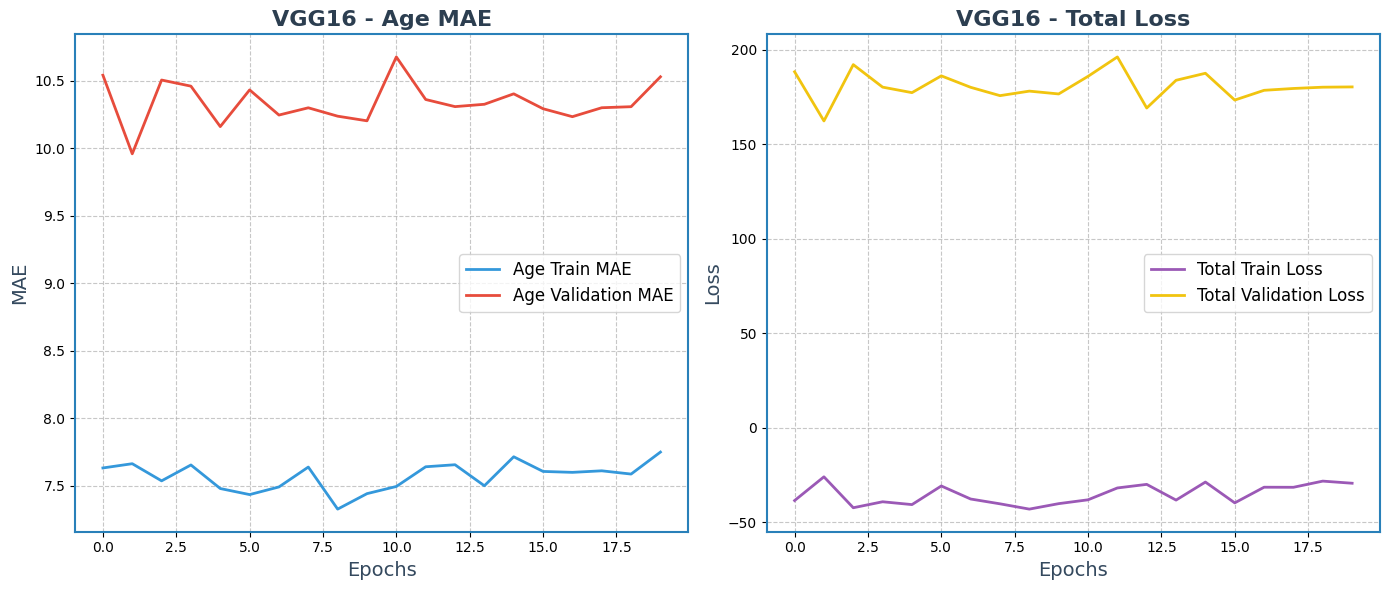

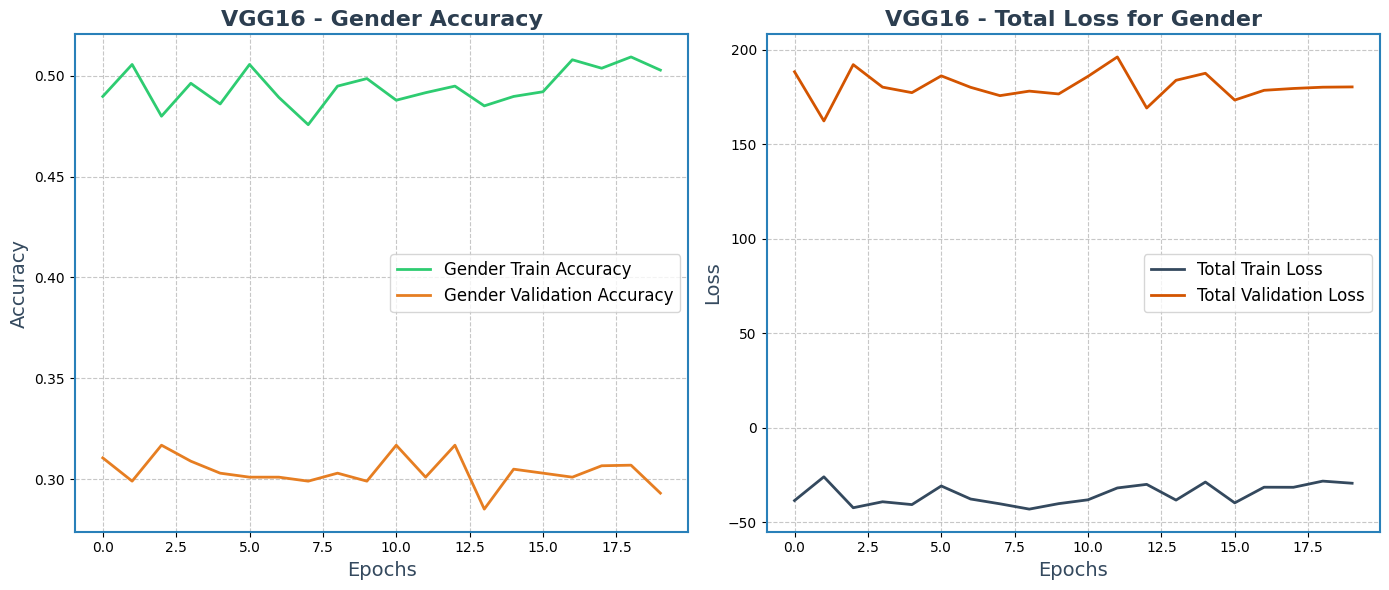

Visualizing metrics for ResNet50...


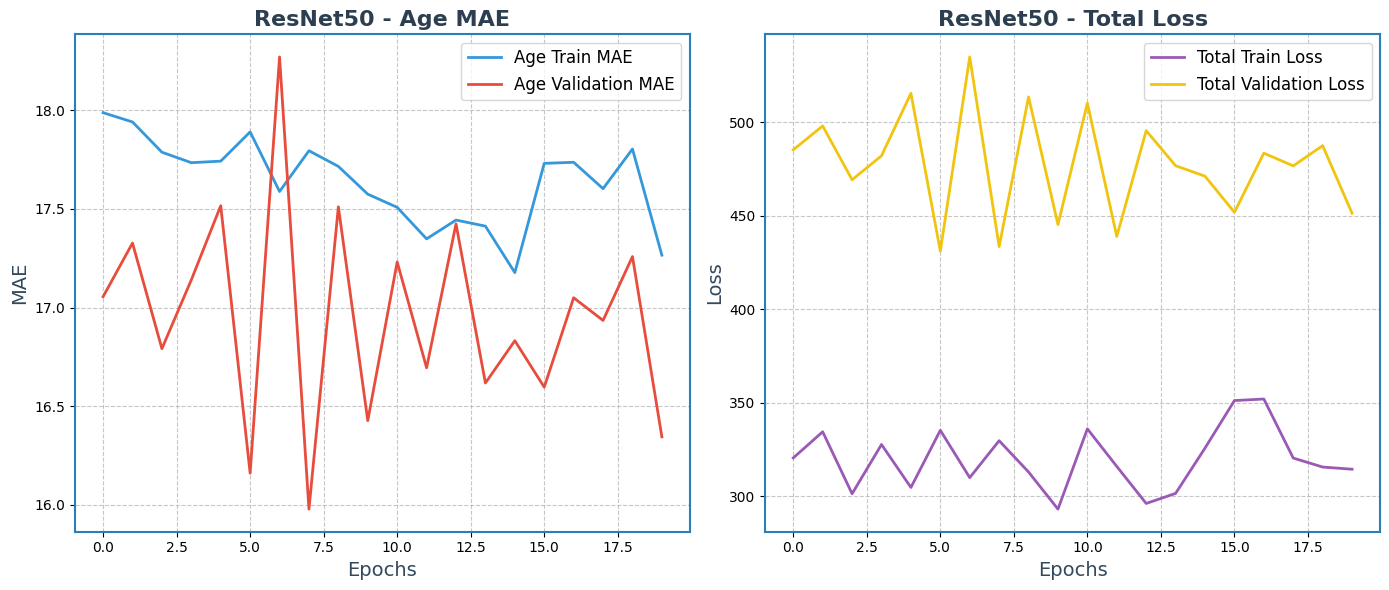

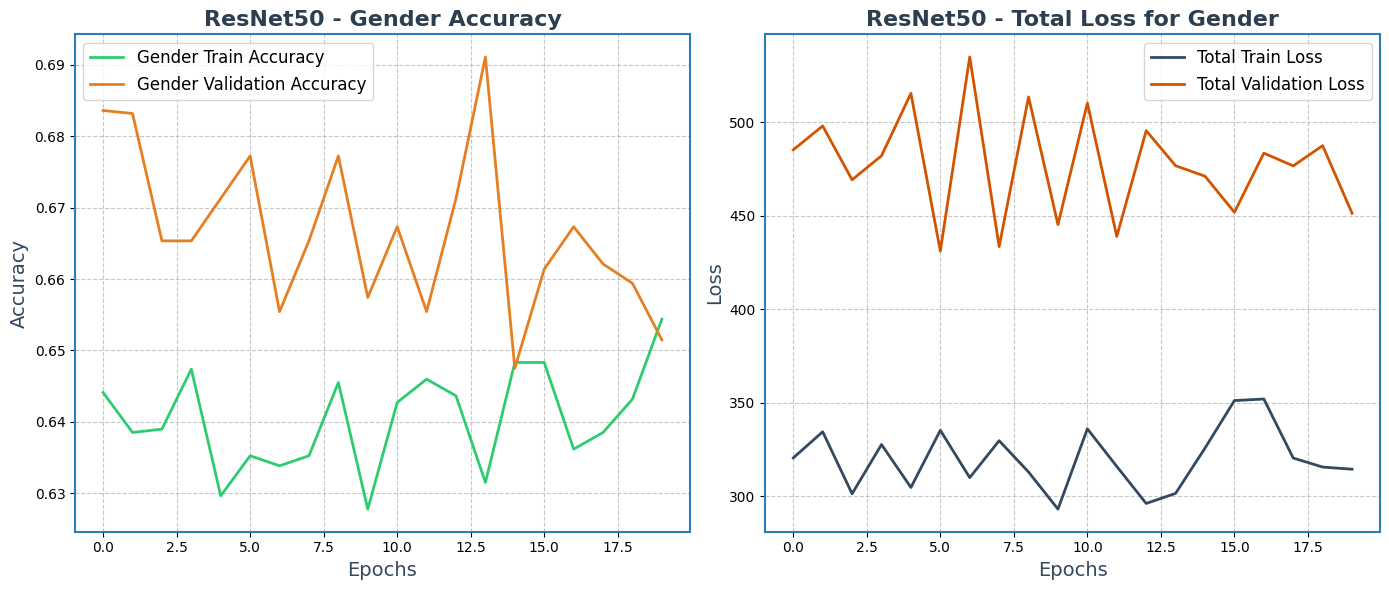

Visualizing metrics for EfficientNetB0...


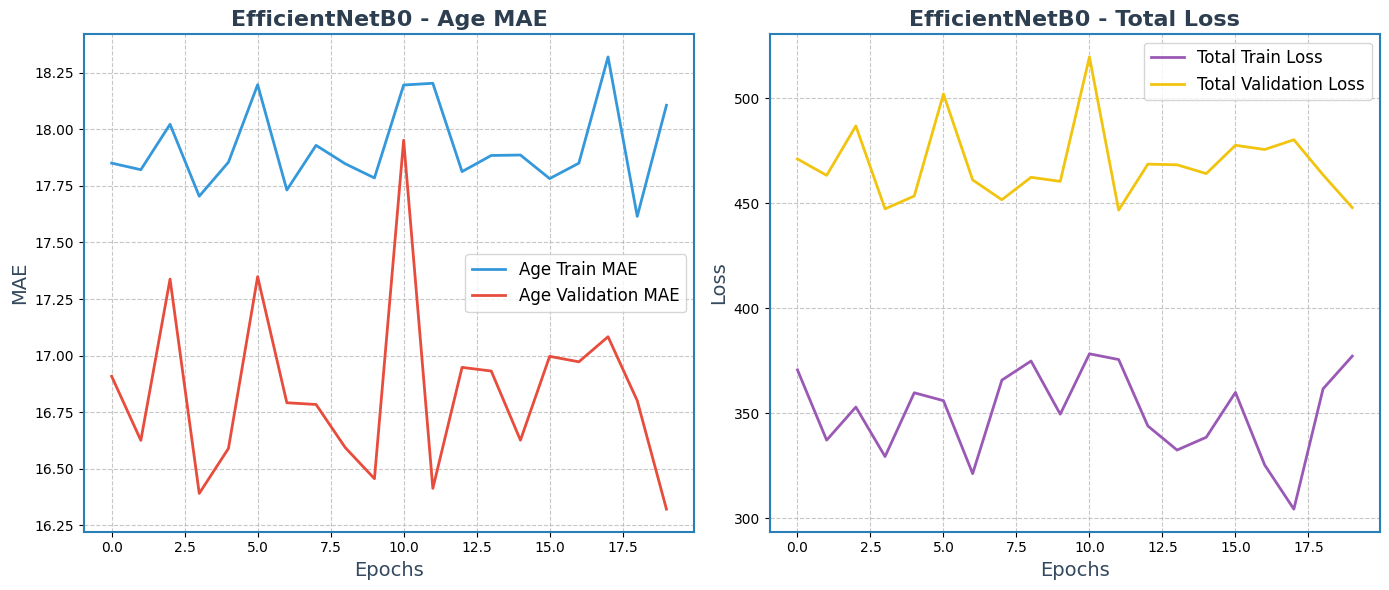

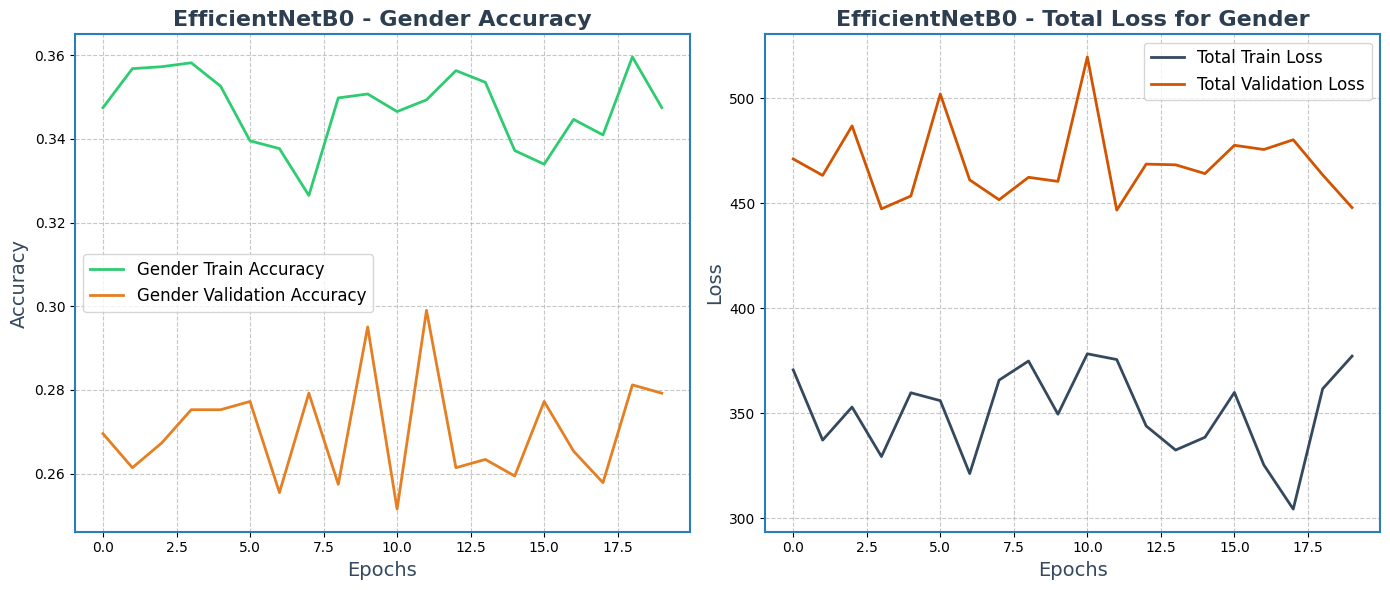

In [ ]:
def style_plot(ax, title, xlabel, ylabel):
    """
    Styles the plot with a title, axis labels, and gridlines.

    Args:
        ax (matplotlib.axes.Axes): The axes object to style.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.

    Returns:
        None
    """
    ax.set_title(title, fontsize=16, fontweight='bold', color="#2c3e50")
    ax.set_xlabel(xlabel, fontsize=14, color="#34495e")
    ax.set_ylabel(ylabel, fontsize=14, color="#34495e")
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    for spine in ax.spines.values():
        spine.set_edgecolor('#2980b9')
        spine.set_linewidth(1.5)

def plot_age_metrics(history, model_name):
    """
    Plots training and validation metrics for age prediction.

    Args:
        history (History): Training history object for a model.
        model_name (str): Name of the model being plotted.

    Returns:
        None
    """
    plt.figure(figsize=(14, 6))

    # Plot MAE for age prediction
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(history.history['age_out_mae'], label='Age Train MAE', color='#3498db', linewidth=2)
    plt.plot(history.history['val_age_out_mae'], label='Age Validation MAE', color='#e74c3c', linewidth=2)
    style_plot(ax1, f'{model_name} - Age MAE', 'Epochs', 'MAE')

    # Plot total loss
    ax2 = plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Total Train Loss', color='#9b59b6', linewidth=2)
    plt.plot(history.history['val_loss'], label='Total Validation Loss', color='#f1c40f', linewidth=2)
    style_plot(ax2, f'{model_name} - Total Loss', 'Epochs', 'Loss')

    plt.tight_layout()
    plt.show()

def plot_gender_metrics(history, model_name):
    """
    Plots training and validation metrics for gender prediction.

    Args:
        history (History): Training history object for a model.
        model_name (str): Name of the model being plotted.

    Returns:
        None
    """
    plt.figure(figsize=(14, 6))

    # Plot accuracy for gender prediction
    ax3 = plt.subplot(1, 2, 1)
    plt.plot(history.history['gender_out_accuracy'], label='Gender Train Accuracy', color='#2ecc71', linewidth=2)
    plt.plot(history.history['val_gender_out_accuracy'], label='Gender Validation Accuracy', color='#e67e22', linewidth=2)
    style_plot(ax3, f'{model_name} - Gender Accuracy', 'Epochs', 'Accuracy')

    # Plot combined loss
    ax4 = plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Total Train Loss', color='#34495e', linewidth=2)
    plt.plot(history.history['val_loss'], label='Total Validation Loss', color='#d35400', linewidth=2)
    style_plot(ax4, f'{model_name} - Total Loss for Gender', 'Epochs', 'Loss')

    plt.tight_layout()
    plt.show()

def visualize_model_metrics(histories):
    """
    Visualizes metrics (loss, MAE, accuracy) for each model in the training histories.

    Args:
        histories (dict): A dictionary where keys are model names and values are training histories.

    Returns:
        None
    """
    for model_name, history in histories.items():
        print(f"Visualizing metrics for {model_name}...")
        plot_age_metrics(history, model_name)
        plot_gender_metrics(history, model_name)

# Workflow
visualize_model_metrics(histories)


In [ ]:
def save_trained_models(models, file_prefix='trained_model'):
    """
    Saves all trained models in the specified dictionary using the recommended Keras format.

    Args:
        models (dict): A dictionary of trained models, where keys are model names and values are model objects.
        file_prefix (str): Prefix for the saved model filenames (default: 'trained_model').

    Returns:
        None
    """
    for model_name, model in models.items():
        filename = f"{file_prefix}_{model_name}.keras"  # Use .keras extension
        model.save(filename)  # Save in the native Keras format
        print(f"Model '{model_name}' saved to '{filename}'.")

# Example Workflow
# After training all models
save_trained_models(models, file_prefix='Age_Gen_Model')


Model 'VGG16' saved to 'Age_Gen_Model_VGG16.keras'.
Model 'ResNet50' saved to 'Age_Gen_Model_ResNet50.keras'.
Model 'EfficientNetB0' saved to 'Age_Gen_Model_EfficientNetB0.keras'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
Predicted Age: 29.2
Predicted Gender: Male


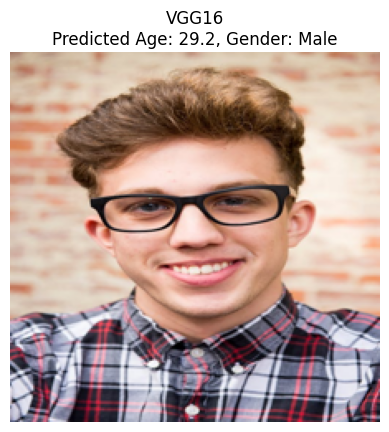

In [ ]:


def load_trained_model(model_path):
    """
    Loads a pre-trained model from the given path.

    Args:
        model_path (str): Path to the pre-trained model file.

    Returns:
        keras.Model: Loaded Keras model.
    """
    return load_model(model_path)

def preprocess_image(image):
    """
    Preprocesses an image for prediction.

    Args:
        image (PIL.Image.Image): Input image.

    Returns:
        np.ndarray: Preprocessed image with batch dimension.
    """
    img_array = img_to_array(image) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def download_image(image_url, target_size=(224, 224)):
    """
    Downloads an image from the given URL and resizes it to the target size.

    Args:
        image_url (str): URL of the image.
        target_size (tuple): Desired size of the image (default is (224, 224)).

    Returns:
        PIL.Image.Image: Downloaded and resized image.
    """
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).resize(target_size)  # Resize to match model input
    return image

def predict_age_gender(model, image_url):
    """
    Predicts the age and gender from an image URL using the given model.

    Args:
        model (keras.Model): Pre-trained Keras model for age and gender prediction.
        image_url (str): URL of the input image.

    Returns:
        dict: Dictionary containing the predicted age and gender.
    """
    # Download and preprocess the image
    downloaded_image = download_image(image_url)
    preprocessed_image = preprocess_image(downloaded_image)

    # Make predictions
    predictions = model.predict(preprocessed_image)
    predicted_age = predictions[0][0][0]  # Age output
    predicted_gender = predictions[1][0][0]  # Gender output (0 or 1)
    gender_label = "Male" if predicted_gender >= 0 else "Female"

    return {
        "age": predicted_age,
        "gender": gender_label,
        "image": downloaded_image
    }

def display_predictions(predictions, model_name="Model"):
    """
    Displays the predicted age, gender, and the corresponding image.

    Args:
        predictions (dict): Dictionary containing predicted age, gender, and image.
        model_name (str): Name of the model used for predictions (default: "Model").
    """
    age = predictions["age"]
    gender = predictions["gender"]
    image = predictions["image"]

    # Print predictions
    print(f"Predicted Age: {age:.1f}")
    print(f"Predicted Gender: {gender}")

    # Display the image with predictions
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(f"{model_name}\nPredicted Age: {age:.1f}, Gender: {gender}")  # Add title with predictions
    plt.show()

# Main workflow
if __name__ == "__main__":
    model_path = 'Age_Gen_Model_VGG16.keras'
    image_url = 'https://images.pexels.com/photos/769772/pexels-photo-769772.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'

    # Load the trained model
    model = load_trained_model(model_path)

    # Predict age and gender
    predictions = predict_age_gender(model, image_url)

    # Display predictions
    display_predictions(predictions, model_name="VGG16")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
Model: VGG16
Predicted Age: 41.6
Predicted Gender: Female


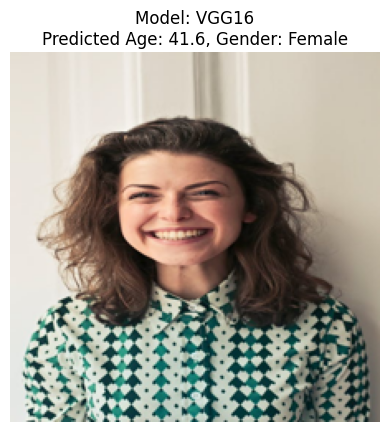

In [ ]:


def load_trained_model(model_path):
    """
    Loads a trained Keras model from the given path.

    Args:
        model_path (str): Path to the trained Keras model file.

    Returns:
        keras.Model: The loaded Keras model.
    """
    return load_model(model_path)

def preprocess_image(image):
    """
    Preprocesses an image for model prediction.

    Args:
        image (PIL.Image.Image): The input image to preprocess.

    Returns:
        np.ndarray: Preprocessed image array with normalization and batch dimension.
    """
    img_array = img_to_array(image) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def download_image(image_url):
    """
    Downloads and resizes an image from a URL.

    Args:
        image_url (str): URL of the image to download.

    Returns:
        PIL.Image.Image: Resized image suitable for model input.
    """
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).resize((224, 224))
    return image

def make_prediction(model, image_url):
    """
    Makes predictions for age and gender using the given model and image URL.

    Args:
        model (keras.Model): The trained Keras model.
        image_url (str): URL of the image to predict on.

    Returns:
        dict: Predicted age, gender, and the original image.
    """
    # Download and preprocess the image
    downloaded_image = download_image(image_url)
    preprocessed_image = preprocess_image(downloaded_image)

    # Make predictions
    predictions = model.predict(preprocessed_image)
    predicted_age = predictions[0][0][0]  # Age output
    predicted_gender = predictions[1][0][0]  # Gender output (0 or 1)

    # Convert gender prediction to label
    gender_label = "Female" if predicted_gender >= 0.5 else "Male"

    return {
        "age": predicted_age,
        "gender": gender_label,
        "image": downloaded_image
    }

def display_prediction(prediction, model_name):
    """
    Displays the predicted age and gender along with the image.

    Args:
        prediction (dict): Dictionary containing predicted age, gender, and image.
        model_name (str): Name of the model used for prediction.
    """
    age = prediction["age"]
    gender = prediction["gender"]
    image = prediction["image"]

    # Print predictions
    print(f"Model: {model_name}")
    print(f"Predicted Age: {age:.1f}")
    print(f"Predicted Gender: {gender}")

    # Display the image with predictions
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(f"Model: {model_name}\nPredicted Age: {age:.1f}, Gender: {gender}")
    plt.show()

# Main workflow
if __name__ == "__main__":
    model_path = 'Age_Gen_Model_VGG16.keras'  # Path to the trained model
    image_url = 'https://images.pexels.com/photos/774909/pexels-photo-774909.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'

    # Load the trained model
    model = load_trained_model(model_path)

    # Make predictions
    prediction = make_prediction(model, image_url)

    # Display the prediction
    display_prediction(prediction, model_name="VGG16")
